In [1]:
import qiskit as qk
import jijmodeling as jm
import jijmodeling.transpiler as jmt
import jijtranspiler_qiskit.qaoa as qaoa
import jijtranspiler_qiskit.qrao as qrao

In [20]:
# TSP

def tsp_model():
    d = jm.Placeholder("d", ndim=2)
    n = d.shape[0]

    x = jm.BinaryVar("x", shape=(n, n))
    i, j, t = [jm.Element(name=name, belong_to=n) for name in ["i", "j", "t"]]

    problem = jm.Problem("TSP")

    problem += jm.sum([i, j, t], d[i, j]*x[i, t]*x[j, (t+1)%n])
    problem += jm.Constraint("one-city", x[:, t] == 1, forall=t)
    problem += jm.Constraint("one-time", x[i, :] == 1, forall=i)

    return problem

problem = tsp_model()
problem

(0.0, 1.0)

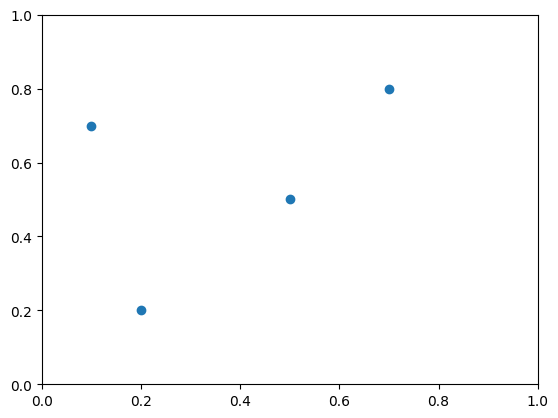

In [40]:
import matplotlib.pyplot as plt
import numpy as np

x = [0.5, 0.7, 0.1, 0.2]
y = [0.5, 0.8, 0.7, 0.2]
n = len(x)
distance = np.zeros((n, n))
for i in range(len(x)):
    for j in range(len(y)):
        distance[i, j] = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)

plt.plot(x, y, "o")
plt.xlim(0, 1)
plt.ylim(0, 1)

In [41]:
fixed_vars = {"x": {(0, 0): 1}}
# fixed_vars["x"].update({(0, i): 0 for i in range(1, n)})
# fixed_vars["x"].update({(i, 0): 0 for i in range(1, n)})
compiled_instance = jmt.core.compile_model(problem, {"d": distance}, fixed_vars)

### QUBO Solver

In [42]:
pubo_builder = jmt.core.pubo.transpile_to_pubo(compiled_instance)
qubo, _ = pubo_builder.get_qubo_dict()

In [43]:
import openjij as oj

sampler = oj.SASampler()
response = sampler.sample_qubo(qubo)

result = jmt.core.pubo.decode_from_openjij(response, pubo_builder, compiled_instance)

In [44]:
result.to_dense().record.solution["x"]

[array([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])]

### Qiskit with QAOA

In [45]:
qaoa_builder = qaoa.transpile_to_qaoa_ansatz(compiled_instance)
hamiltonian, _ = qaoa_builder.get_hamiltonian()

In [50]:
import qiskit.circuit as qk_circ
import qiskit.primitives as qk_p
from scipy.optimize import minimize

qaoa_ansatz = qk_circ.library.QAOAAnsatz(hamiltonian)

def cost_func(parameters, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=parameters).result().values[0]
    return cost

# Run QAOA
initial_params = [1.0, 0.6]
estimator = qk_p.Estimator()
optimization_history = []
qaoa_result = minimize(cost_func, initial_params, args=(qaoa_ansatz, hamiltonian, estimator), method='COBYLA',callback = lambda x:optimization_history.append(cost_func(x,qaoa_ansatz, hamiltonian, estimator)))

# Sample QAOA results
qaoa_ansatz.measure_all()
sampler = qk_p.Sampler()
job = sampler.run(qaoa_ansatz, qaoa_result.x)
result = job.result().quasi_dists
qaoa_results = qaoa_builder.decode_from_quasi_dist(result[0])

In [61]:
qaoa_results.lowest().to_dense().record.solution["x"]

[array([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])]

## QRAO

In [59]:
qrac_builder = qrao.transpile_to_qrac31_hamiltonian(compiled_instance)
qrac_hamiltonian = qrac_builder.get_hamiltonian()

In [4]:
import typing as typ

def qubo_greedy_coloring(
    qubo: dict[tuple[int, int], float],
    max_color_group_size: int,
    init_coloring: typ.Optional[dict[int, int]] = None,
)->tuple[dict[int, int], dict[int, list[int]]]:
    coloring = {}
    if init_coloring:
        coloring.update(init_coloring)
    
    max_color = max(coloring.values()) if coloring else -1

    adj_matrix: dict[int, list[int]] = {}
    for i, j in qubo.keys():
        if i == j:
            continue
        if i not in adj_matrix:
            adj_matrix[i] = []
        if j not in adj_matrix:
            adj_matrix[j] = []
        adj_matrix[i].append(j)
        adj_matrix[j].append(i)
    
    color_group: dict[int, list[int]] = {}
    for index, color in coloring.items():
        if color not in coloring:
            color_group[color] = []
        color_group[color].append(index)

    for i, neigborhoors in adj_matrix.items():
        if i in coloring:
            continue

        neighbor_colors = [coloring[k] for k in neigborhoors if k in coloring]

        done_coloring = False
        for color in range(max_color+1):
            if color not in color_group or color not in neighbor_colors:
                if color not in color_group or max_color_group_size > len(color_group[color]):
                    coloring[i] = color
                    done_coloring = True
                    if color not in color_group:
                        color_group[color] = []
                    color_group[color].append(i)
                    break
        if not done_coloring:
            coloring[i] = max_color + 1
            color_group[max_color + 1] = [i]
            max_color += 1
            
    return coloring, color_group 

In [5]:
qubo = {(0, 1): -1.0, (1, 1): 1.0, (1, 2): -0.1, (2, 0): 1, (2, 3): 1}
coloring, color_group = qubo_greedy_coloring(qubo, 2)
coloring, color_group

({0: 0, 1: 1, 2: 2, 3: 0}, {0: [0, 3], 1: [1], 2: [2]})

In [17]:
import enum
class Pauli(enum.Enum):
    X = enum.auto()
    Y = enum.auto()
    Z = enum.auto()

def color_group_to_qrac31_encode(color_group: dict[int, list[int]]):
    qrac31 = {}
    pauli_ope = [Pauli.Z, Pauli.X, Pauli.Y]
    for color, group in color_group.items():
        for ope_idx, bit_index in enumerate(group):
            qrac31[bit_index] = (color, pauli_ope[ope_idx])
    return qrac31

color_guroup = color_group_to_qrac31_encode(color_group)
color_guroup

{0: (0, <Pauli.Z: 3>),
 3: (0, <Pauli.X: 1>),
 1: (1, <Pauli.Z: 3>),
 2: (2, <Pauli.Z: 3>)}

In [18]:
import numpy as np
import qiskit.quantum_info as qk_ope
from jijtranspiler_qiskit.ising_qubo.ising_qubo import qubo_to_ising


def qrac31_encode(qubo: dict[tuple[int, int], float], color_group: dict[int, list[int]]):
    ising = qubo_to_ising(qubo)

    encoded_ope = color_group_to_qrac31_encode(color_group)

    pauli_terms: list[qk_ope.SparsePauliOp] = []

    offset = ising.constant
    n_qubit = len(color_group)
    zero = np.zeros(n_qubit, dtype=bool)

    operator_parity = {Pauli.X: (False, True), Pauli.Y: (True, False), Pauli.Z: (True, False)}

    # convert linear parts of the objective function into Hamiltonian.
    for idx, coef in ising.linear.items():
        if coef == 0.0:
            continue
 
        weight = coef
        color, idx_pauli = encoded_ope[idx]
        z_parity, x_parity = operator_parity[idx_pauli]
        if z_parity:
            z_p = zero.copy()
            z_p[color] = True
        else:
            z_p = zero

        if x_parity:
            x_p = zero.copy()
            x_p[color] = True
        else:
            x_p = zero

        pauli_terms.append(qk_ope.SparsePauliOp(qk_ope.Pauli((z_p, x_p)), weight))
        offset += weight

    # create Pauli terms
    for (i, j), coeff in ising.quad.items():
        if coeff == 0.0:
            continue

        weight = coeff

        if i == j:
            offset += weight
            continue

        color_i, pauli_i_index = encoded_ope[i]
        zi_p, xi_p = operator_parity[pauli_i_index]

        color_j, pauli_j_index = encoded_ope[j]
        zj_p, xj_p = operator_parity[pauli_j_index]

        if zi_p or zj_p:
            z_p = zero.copy()
            z_p[color_i] = zi_p
            z_p[color_j] = zj_p
        else:
            z_p = zero

        if xi_p or xj_p:
            x_p = zero.copy()
            x_p[color_i] = xi_p
            x_p[color_j] = xj_p
        else:
            x_p = zero

        pauli_terms.append(qk_ope.SparsePauliOp(qk_ope.Pauli((z_p, x_p)), weight))


    if pauli_terms:
        # Remove paulis whose coefficients are zeros.
        qubit_op = sum(pauli_terms).simplify(atol=0)
    else:
        # If there is no variable, we set num_nodes=1 so that qubit_op should be an operator.
        # If num_nodes=0, I^0 = 1 (int).
        n_qubit = max(1, n_qubit)
        qubit_op = qk_ope.SparsePauliOp("I" * n_qubit, 0)

    return qubit_op, offset


In [19]:
qrac31_encode(qubo, color_group)

(SparsePauliOp(['IZI', 'ZII', 'IIX', 'IZZ', 'ZZI', 'ZIZ', 'ZIX'],
               coeffs=[ 0.225+0.j,  0.475+0.j,  0.25 +0.j, -0.25 +0.j, -0.025+0.j,  0.25 +0.j,
   0.25 +0.j]),
 -0.22499999999999998)

In [20]:
qubo

{(0, 1): -1.0, (1, 1): 1.0, (1, 2): -0.1, (2, 0): 1, (2, 3): 1}

In [21]:
color_guroup

{0: (0, <Pauli.Z: 3>),
 3: (0, <Pauli.X: 1>),
 1: (1, <Pauli.Z: 3>),
 2: (2, <Pauli.Z: 3>)}